<a href="https://colab.research.google.com/github/akashc1/projects/blob/master/PAC_research_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://aicare.stanford.edu/sep2020.tar.gz
!tar -xvf sep2020.tar.gz

--2020-09-19 02:03:11--  https://aicare.stanford.edu/sep2020.tar.gz
Resolving aicare.stanford.edu (aicare.stanford.edu)... 171.64.68.86
Connecting to aicare.stanford.edu (aicare.stanford.edu)|171.64.68.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224617454 (214M) [application/x-gzip]
Saving to: ‘sep2020.tar.gz.6’

sep2020.tar.gz.6    100%[===================>] 214.21M  79.2MB/s    in 2.7s    

2020-09-19 02:03:14 (79.2 MB/s) - ‘sep2020.tar.gz.6’ saved [224617454/224617454]

hh_data/
hh_data/labels.json
hh_data/mp4/
hh_data/mp4/368.mp4
hh_data/mp4/126.mp4
hh_data/mp4/475.mp4
hh_data/mp4/047.mp4
hh_data/mp4/263.mp4
hh_data/mp4/335.mp4
hh_data/mp4/101.mp4
hh_data/mp4/070.mp4
hh_data/mp4/068.mp4
hh_data/mp4/066.mp4
hh_data/mp4/029.mp4
hh_data/mp4/053.mp4
hh_data/mp4/074.mp4
hh_data/mp4/090.mp4
hh_data/mp4/450.mp4
hh_data/mp4/124.mp4
hh_data/mp4/064.mp4
hh_data/mp4/465.mp4
hh_data/mp4/359.mp4
hh_data/mp4/079.mp4
hh_data/mp4/448.mp4
hh_data/mp4/004.mp4
hh_data

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import cv2, sys, os
import matplotlib.pyplot as plt
from pathlib import Path
import json

plt.rcParams["figure.figsize"] = (15, 15)
label_data_file = Path('hh_data') / 'labels.json'

In [3]:
!ls hh_data/npy | sort

001.npy
002.npy
003.npy
004.npy
005.npy
006.npy
007.npy
008.npy
011.npy
012.npy
013.npy
014.npy
015.npy
018.npy
020.npy
021.npy
022.npy
023.npy
024.npy
025.npy
026.npy
027.npy
028.npy
029.npy
031.npy
032.npy
033.npy
034.npy
035.npy
036.npy
037.npy
038.npy
040.npy
041.npy
042.npy
043.npy
044.npy
046.npy
047.npy
048.npy
049.npy
050.npy
051.npy
053.npy
054.npy
055.npy
056.npy
057.npy
058.npy
059.npy
060.npy
061.npy
062.npy
063.npy
064.npy
065.npy
066.npy
067.npy
068.npy
069.npy
070.npy
071.npy
072.npy
073.npy
074.npy
076.npy
077.npy
078.npy
079.npy
080.npy
081.npy
082.npy
083.npy
084.npy
085.npy
086.npy
087.npy
089.npy
090.npy
091.npy
093.npy
095.npy
096.npy
097.npy
098.npy
099.npy
100.npy
101.npy
102.npy
103.npy
104.npy
105.npy
106.npy
107.npy
108.npy
109.npy
110.npy
111.npy
112.npy
113.npy
114.npy
115.npy
117.npy
118.npy
119.npy
120.npy
121.npy
122.npy
123.npy
124.npy
125.npy
126.npy
127.npy
129.npy
130.npy
131.npy
132.npy
133.npy
135.npy
136.npy
137.npy
138.npy
139.npy
140.npy
141.npy


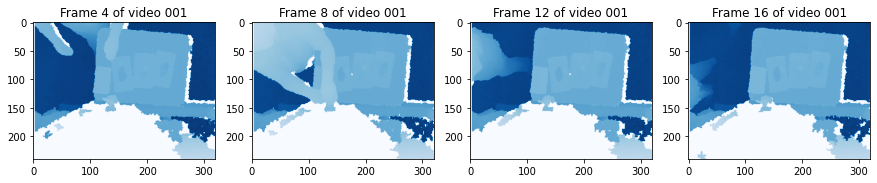

In [4]:
test_vid = np.load('hh_data/npy/001.npy').astype(np.float32)
test_vid.shape

for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.title(f'Frame {4 * i} of video 001')
    plt.imshow(test_vid[4 * i], cmap='Blues')


In [5]:
with open(label_data_file, 'r') as f:
    labels = json.load(f)

In [6]:
num_vids_npy = len(os.listdir('hh_data/npy'))
num_vids_mp4 = len(os.listdir('hh_data/mp4'))
print(f"num_labels: {len(labels)}\tnum_npy: {num_vids_npy}\tnum_mp4: {num_vids_mp4}")

num_labels: 485	num_npy: 302	num_mp4: 302


In [7]:
npy_data_path = Path('hh_data/npy')
npy_files = sorted(os.listdir(npy_data_path))

ind_numid_map = {}
all_x, all_y, weighted_y, all_ids = [], [], [], []
for i, filename in enumerate(npy_files):
    example_num_str = filename.strip().split('.')[0]
    all_x.append(torch.Tensor(np.load(npy_data_path / filename).astype(np.float32)))
    all_y.append(int(labels[example_num_str]['is_clean']))
    all_ids.append(int(example_num_str))

    ind_numid_map[int(example_num_str)] = i

    for _ in range(len(all_x[-1])):
        weighted_y.append(int(labels[example_num_str]['is_clean']))


(array([174., 128.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

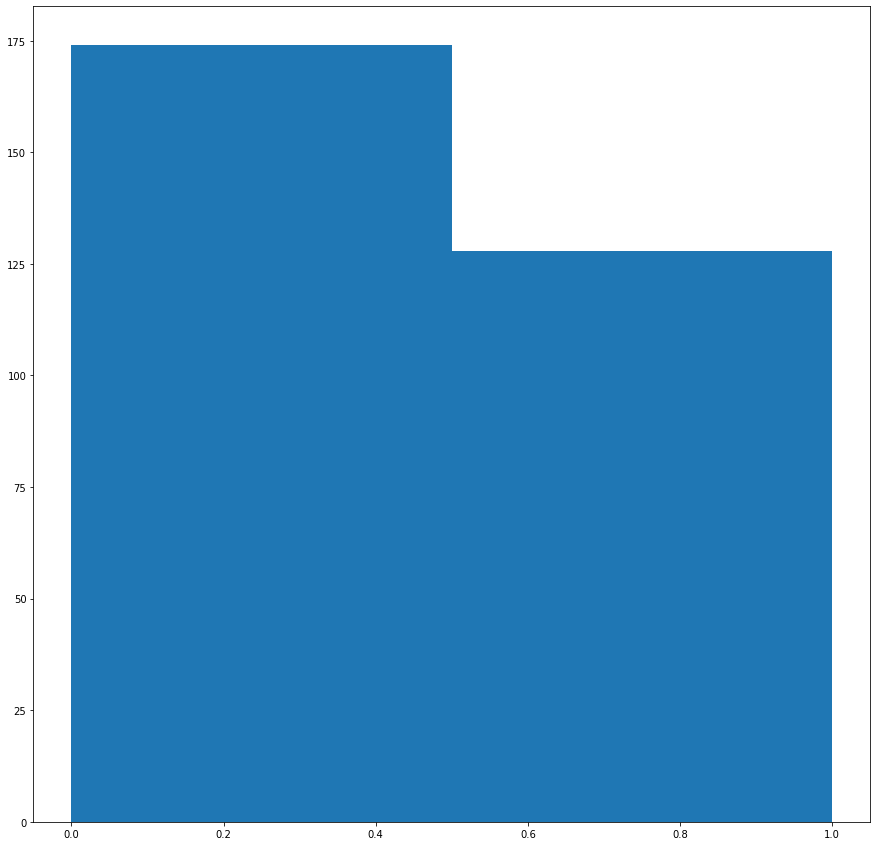

In [8]:
plt.hist(all_y, bins=[0, 0.5, 1])

(array([5390., 4444.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

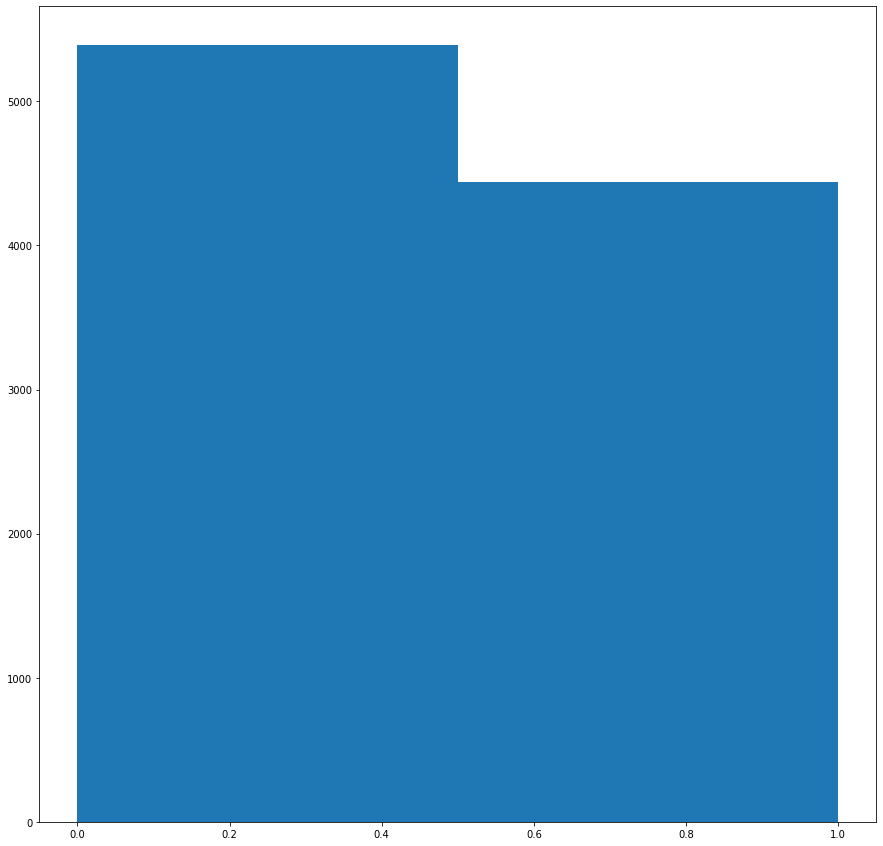

In [9]:
plt.hist(weighted_y, bins=[0, 0.5, 1])

In [10]:
"""
Helper to get an example from the whole dataset
given either a numeric or string representation
of the example's id (ie. both '302' and 302 would work)
"""
def get_example(all_x: list, all_y: list, int_id_map: dict, num_id: int=None, str_id: str=None, index=None):
    
    if num_id is None and str_id is None:
        raise ValueError("Must provide either integer or string id of example!")

    if index is None:
        id = int(str_id) if str_id is not None else num_id
        ind = int_id_map[id]
    else:
        ind = index
    
    num_frames = len(all_x[ind])
    example_y = torch.tensor([all_y[ind] for _ in range(num_frames)], dtype=torch.long)
    
    return torch.unsqueeze(all_x[ind], 1), example_y


"""
Helper to get an example's metadata from the whole dataset
given either a numeric or string representation
of the example's id (ie. both '302' and 302 would work)
"""
def get_metadata(int_id_map: dict, labels: dict, num_id: int=None, str_id: str=None):

    if num_id is None and str_id is None:
        raise ValueError("Must provide either integer or string id of example!")

    id = str_id if str_id is not None else str(num_id)
    return labels[id]

In [11]:
import torchvision
from torchvision import models

# Freeze feature parameters, allow classifier parameters to train
torch.manual_seed(20)
transfer_model = models.resnet50(pretrained=True)
ct = 0

for child in transfer_model.children():
    ct += 1
    if ct < 8:
        for param in child.parameters():
            param.requires_grad = False
           
transfer_model.fc = torch.nn.Sequential(
                        torch.nn.Linear(2048, 256),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(0.4),
                        torch.nn.Linear(256, 2),
                        torch.nn.Softmax(dim=1))

transfer_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

transfer_model.cuda()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
from sklearn.model_selection import train_test_split

def report_metrics(model, x, y, verbose=False):

    with torch.no_grad():

        model.eval()
        logits = model(x)
        loss = float(F.cross_entropy(logits, y).item())
        prob, y_hat = torch.max(logits, 1)


        if torch.cuda.is_available():
            y = y.cpu()
            y_hat = y_hat.cpu()
        
        accuracy = (y == y_hat).numpy().astype(np.float).mean()

        if verbose:
            print(f"Random logits: [{float(logits[0, 0]):.4f}, {float(logits[0, 1]):.4f}")

        del x, y, y_hat, logits

    return loss, accuracy

def train(model, all_data, train_ids, val_ids, int_id_map, epochs=1, lr=3e-3, wd=1e-5):

    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    all_x, all_y = all_data
    all_loss = []

    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):

        np.random.shuffle(train_ids)
        temp_train_loss, temp_train_acc = [], []

        for step, ex_id in enumerate(train_ids):

            x, y = get_example(all_x, all_y, ind_numid_map, num_id=ex_id)

            for ts, (x_i, y_i) in enumerate(zip(x, y)):
                x_i = torch.unsqueeze(x_i, 0).to(device)
                y_i = torch.unsqueeze(y_i, 0).to(device)

                model.train()
                logits = model(x_i)
                loss = F.cross_entropy(logits, y_i)
                all_loss.append(float(loss.item()))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                temp_train_loss.append(float(loss.item()))
                temp_train_acc.append(int(torch.max(logits, 1)[1] == y_i[0]))
                del logits, loss
                torch.cuda.empty_cache()

                if step % 10 == 0:
                    loss, accuracy = report_metrics(model, x_i, y_i)
                    train_loss.append(loss)
                    train_acc.append(accuracy)
                    del accuracy

                del x_i, y_i
                torch.cuda.empty_cache()

        temp_val_loss, temp_val_acc = [], []
        for step, ex_id in enumerate(val_ids):

            x, y = get_example(all_x, all_y, ind_numid_map, num_id=ex_id)
            for ts, (x_i, y_i) in enumerate(zip(x, y)):
                x_i = torch.unsqueeze(x_i, 0).to(device)
                y_i = torch.unsqueeze(y_i, 0).to(device)
           
                loss, accuracy = report_metrics(model, x_i, y_i)
                temp_val_loss.append(loss)
                temp_val_acc.append(accuracy)
            
                del x_i, y_i, loss, accuracy
                torch.cuda.empty_cache()
        
        val_loss.append(np.mean(temp_val_loss))
        val_acc.append(np.mean(temp_val_acc))
        torch.cuda.empty_cache()

        print(f"Epoch: {epoch}")
        print(f"Train loss: {np.mean(temp_train_loss)}\tTrain acc: {np.mean(temp_train_acc)}")
        print(f"Validation loss: {val_loss[-1]}\tValidation acc: {val_acc[-1]}")

    return train_loss, val_loss, train_acc, val_acc, all_loss


            


In [13]:
train_ids, val_ids = train_test_split(all_ids, train_size=0.8, random_state=20)

train_loss, val_loss, train_acc, val_acc, all_loss = train(transfer_model,
                                                 all_data=(all_x, all_y),
                                                 train_ids=train_ids, val_ids=val_ids,
                                                 int_id_map=ind_numid_map,
                                                 epochs=3, lr=1e-1)

cuda:0
Epoch: 0
Train loss: 0.7893530136547918	Train acc: 0.5237189244038559
Validation loss: 0.6830052366776345	Validation acc: 0.6302564102564102
Epoch: 1
Train loss: 0.7996970294114298	Train acc: 0.5135717909690513
Validation loss: 0.9435180494265678	Validation acc: 0.36974358974358973
Epoch: 2
Train loss: 0.8509640165924542	Train acc: 0.4623287671232877
Validation loss: 0.9435180494265678	Validation acc: 0.36974358974358973


In [14]:
model_pth = 'resnet_50_pac_transfer_1.torch'
torch.save(transfer_model, model_pth)


In [15]:
def decode_val_output(model, all_data, val_ids, int_id_map):

    metrics_df = pd.DataFrame(columns=['id', 'gt', 'avg_score_all', 'avg_prob_all'])
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for ex_id in val_ids:

        x, y = get_example(all_x, all_y, ind_numid_map, num_id=ex_id)
        ts_scores = []
        probs = []
        for ts, (x_i, y_i) in enumerate(zip(x, y)):

            model.eval()
            x_i = torch.unsqueeze(x_i, 0).to(device)
            y_i = torch.unsqueeze(y_i, 0).to(device)
            gt = int(y_i.cpu()[0])
            logits = model(x_i)
            prob, y_hat = torch.max(logits, 1)
            ts_scores.append(int(y_hat))
            probs.append(float(prob))
            
            del x_i, y_i, logits
            torch.cuda.empty_cache()
        
        metrics_df = metrics_df.append(
            {
                'id': ex_id,
                'gt': gt,
                'avg_score_all': np.mean(ts_scores),
                'avg_prob_all': np.mean(probs)
            }, ignore_index=True)
        
        #print(f"Avg. prob on example {ex_id}: {np.mean(probs):.4f}")
            
    return metrics_df               

In [16]:
df = decode_val_output(transfer_model, (all_x, all_y), val_ids, ind_numid_map)
df.head()

,id,gt,avg_score_all,avg_prob_all
0,344.0,1.0,1.0,1.0
1,133.0,0.0,1.0,1.0
2,330.0,1.0,1.0,1.0
3,89.0,1.0,1.0,1.0
4,35.0,0.0,1.0,1.0


In [17]:
avg_score = np.mean(df['avg_score_all'])
print(f"Average video score: {avg_score:.2f}")

df['pred'] = (df['avg_score_all'] > 0.5).astype(int)
df['correct'] = (df['pred'] == df['gt']).astype(int)
df.head()

Average video score: 1.00


,id,gt,avg_score_all,avg_prob_all,pred,correct
0,344.0,1.0,1.0,1.0,1,1
1,133.0,0.0,1.0,1.0,1,0
2,330.0,1.0,1.0,1.0,1,1
3,89.0,1.0,1.0,1.0,1,1
4,35.0,0.0,1.0,1.0,1,0


In [18]:
df['sensor'] = df.apply(lambda x: labels[str(int(x['id'])).zfill(3)]['room'], axis=1)
df['timestamp'] = df.apply(lambda x: labels[str(int(x['id'])).zfill(3)]['ts'], axis=1)
df['TP'] = np.logical_and(df['gt'], df['pred']).astype(int)
df['FP'] = np.logical_and(1 - df['gt'], df['pred']).astype(int)
df['FN'] = np.logical_and(df['gt'], 1 - df['pred']).astype(int)
df['TN'] = np.logical_and(1 - df['gt'], 1 - df['pred']).astype(int)

TP, FP, TN, FN = sum(df['TP']), sum(df['FP']), sum(df['TN']), sum(df['FN'])

precision = TP / (TP + FP)
sensitivity = recall = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"""
        Precision: {precision:.3f}\t
        Sensitivity/Recall: {recall:.3f}\t
        Specificity: {specificity:.3f}
        """)


        Precision: 0.361	
        Sensitivity/Recall: 1.000	
        Specificity: 0.000
        


Text(0.5, 1.0, 'False Negative sensor distribution')

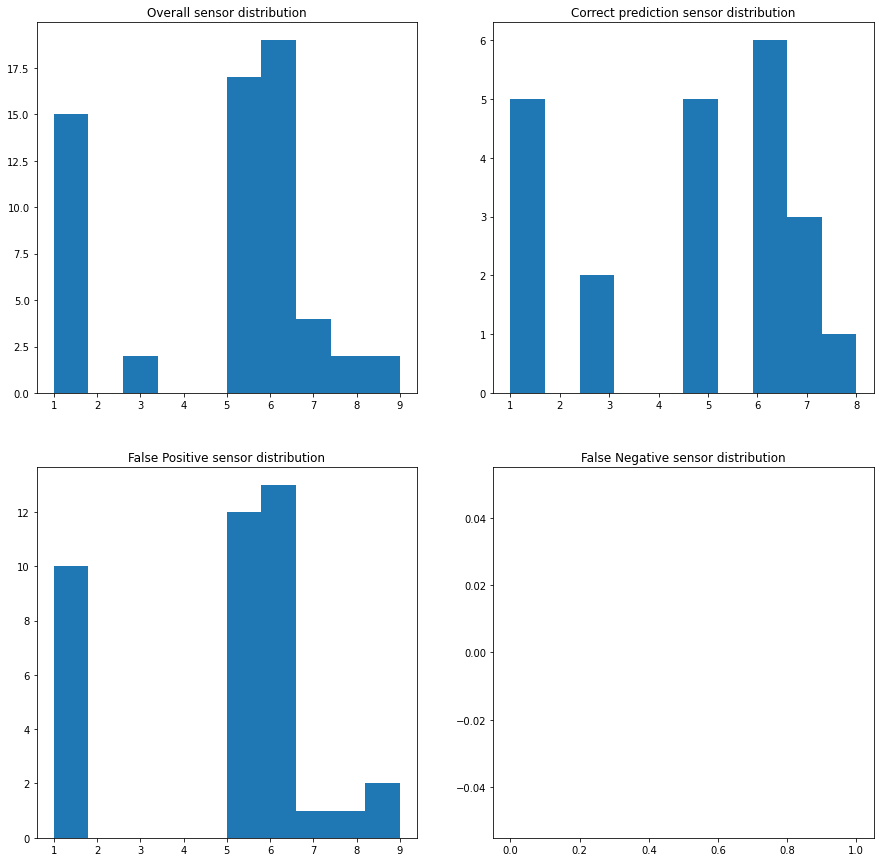

In [19]:
all_sensors = df['sensor']
fp_sensors = df[df['FP'] == 1]['sensor']
fn_sensors = df[df['FN'] == 1]['sensor']
correct_sensors = df[df['correct'] == 1]['sensor']

plt.subplot(2, 2, 1)
plt.hist(all_sensors)
plt.title('Overall sensor distribution')

plt.subplot(2, 2, 2)
plt.hist(correct_sensors)
plt.title('Correct prediction sensor distribution')

plt.subplot(2, 2, 3)
plt.hist(fp_sensors)
plt.title('False Positive sensor distribution')

plt.subplot(2, 2, 4)
plt.hist(fn_sensors)
plt.title('False Negative sensor distribution')

In [29]:
final_val_acc = np.mean((df['gt'] == df['pred']).astype(int))
print(f"Final validation accuracy of transfer model: {final_val_acc}")

Final validation accuracy of transfer model: 0.36065573770491804


In [20]:
simple_model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), bias=False),
    torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False),
    torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False),
    torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), bias=False),
    torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
    torch.nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(70224, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Softmax(dim=1)
)



In [21]:
train_ids, val_ids = train_test_split(all_ids, train_size=0.8, random_state=20)

(simple_train_loss,
 simple_val_loss,
 simple_train_acc, 
 simple_val_acc, 
 simple_all_loss) = train(simple_model,
                        all_data=(all_x, all_y),
                        train_ids=train_ids, val_ids=val_ids,
                        int_id_map=ind_numid_map,
                        epochs=3, lr=3e-3)

cuda:0
Epoch: 0
Train loss: 0.7605872157297723	Train acc: 0.5527650938609843
Validation loss: 0.6830052565611325	Validation acc: 0.6302564102564102
Epoch: 1
Train loss: 0.8483707698006305	Train acc: 0.46486555048198885
Validation loss: 0.6830052366776345	Validation acc: 0.6302564102564102
Epoch: 2
Train loss: 0.7772346075788662	Train acc: 0.5360223236935566
Validation loss: 0.6830052366776345	Validation acc: 0.6302564102564102


In [22]:
model_pth = 'simple_pac_1.torch'
torch.save(simple_model, model_pth)

In [23]:
simple_df = decode_val_output(simple_model, (all_x, all_y), val_ids, ind_numid_map)
simple_df.head()

,id,gt,avg_score_all,avg_prob_all
0,344.0,1.0,0.0,1.0
1,133.0,0.0,0.0,1.0
2,330.0,1.0,0.0,1.0
3,89.0,1.0,0.0,1.0
4,35.0,0.0,0.0,1.0


In [24]:
avg_score = np.mean(df['avg_score_all'])
print(f"Average video score: {avg_score:.2f}")

simple_df['pred'] = (simple_df['avg_score_all'] > 0.5).astype(int)
simple_df['correct'] = (simple_df['pred'] == simple_df['gt']).astype(int)
simple_df['sensor'] = simple_df.apply(lambda x: labels[str(int(x['id'])).zfill(3)]['room'], axis=1)
simple_df['timestamp'] = simple_df.apply(lambda x: labels[str(int(x['id'])).zfill(3)]['ts'], axis=1)
simple_df['TP'] = np.logical_and(simple_df['gt'], simple_df['pred']).astype(int)
simple_df['FP'] = np.logical_and(1 - simple_df['gt'], simple_df['pred']).astype(int)
simple_df['FN'] = np.logical_and(simple_df['gt'], 1 - simple_df['pred']).astype(int)
simple_df['TN'] = np.logical_and(1 - simple_df['gt'], 1 - simple_df['pred']).astype(int)
simple_df.head()

Average video score: 1.00


,id,gt,avg_score_all,avg_prob_all,pred,correct,sensor,timestamp,TP,FP,FN,TN
0,344.0,1.0,0.0,1.0,0,0,5,1548360291000,0,0,1,0
1,133.0,0.0,0.0,1.0,0,1,6,1548184526000,0,0,0,1
2,330.0,1.0,0.0,1.0,0,0,5,1548359160000,0,0,1,0
3,89.0,1.0,0.0,1.0,0,0,6,1548180873000,0,0,1,0
4,35.0,0.0,0.0,1.0,0,1,1,1548187530000,0,0,0,1



        Precision: 0.000	
        Sensitivity/Recall: 0.000	
        Specificity: 1.000
        


Text(0.5, 1.0, 'False Negative sensor distribution')

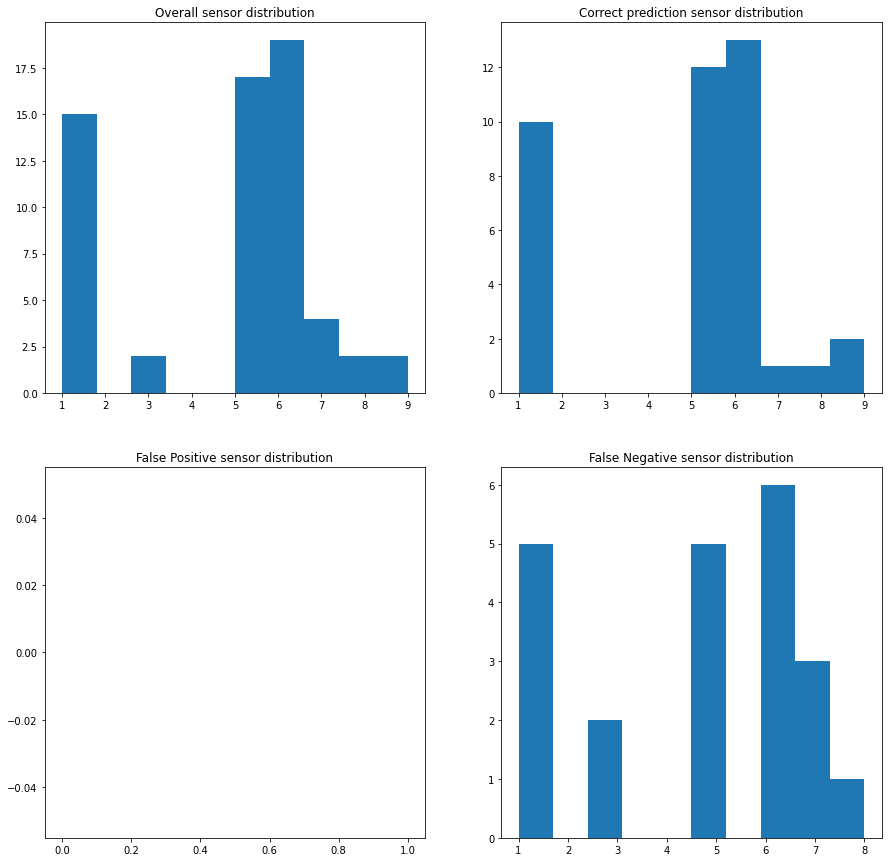

In [26]:
TP, FP, TN, FN = sum(simple_df['TP']), sum(simple_df['FP']), sum(simple_df['TN']), sum(simple_df['FN'])

precision = TP / (TP + FP) if TP + FP > 0 else 0
sensitivity = recall = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"""
        Precision: {precision:.3f}\t
        Sensitivity/Recall: {recall:.3f}\t
        Specificity: {specificity:.3f}
        """)

all_sensors = simple_df['sensor']
fp_sensors = simple_df[simple_df['FP'] == 1]['sensor']
fn_sensors = simple_df[simple_df['FN'] == 1]['sensor']
correct_sensors = simple_df[simple_df['correct'] == 1]['sensor']

plt.subplot(2, 2, 1)
plt.hist(all_sensors)
plt.title('Overall sensor distribution')

plt.subplot(2, 2, 2)
plt.hist(correct_sensors)
plt.title('Correct prediction sensor distribution')

plt.subplot(2, 2, 3)
plt.hist(fp_sensors)
plt.title('False Positive sensor distribution')

plt.subplot(2, 2, 4)
plt.hist(fn_sensors)
plt.title('False Negative sensor distribution')

In [28]:
final_val_acc = np.mean((simple_df['gt'] == simple_df['pred']).astype(int))
print(f"Final validation accuracy of simple model: {final_val_acc}")

Final validation accuracy of simple model: 0.639344262295082
